<a href="https://colab.research.google.com/github/jinyingtld/python/blob/main/AI6126_tutorial4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ESRGAN：增强的超分辨率生成对抗网络(ESRGAN: Enhanced Super-Resolution Generative Adversarial Networks)

## 简述
SRGAN的输出与ESRGAN的输出，生成的HR图像是LR输入的四倍。ESRGAN在锐度和细节方面优于其前身。
SRGAN是2017年超分辨率（SR）算法领域的最先进技术。它的任务是拍摄低分辨率（LR）图像并输出其高分辨率（HR）表示。网络的第一个优化目标时最小化恢复的HR图像和地面实况之间的均方差(MSE). 这相当于最大化峰值信噪比(PSNR), 这是用于评估SR算法的常用度量。然而，这有利于过于光滑的纹理。这就是为什么网络的第二个目标是尽量减少感知损失。这有助于捕获纹理细节和高频内容。结果，网络已经学会在这两个相互矛盾的目标之间找到一个最佳点。通过强制GAN跟踪目标，网络产生LR输入的高质量HR表示。一年后，SRGAN方法（由Twitter的科学家创建）得到了中国和新加坡研究人员的改进。新网络可以创建更逼真的纹理。这是通过几个聪明的技巧实现的。
[image](https://upload-images.jianshu.io/upload_images/17144-338dd2bb2140dd23?imageMogr2/auto-orient/strip|imageView2/2/w/954/format/webp) [网址](https://www.jianshu.com/p/1c30213ee7b7)
SRGAN基于ResNet架构。尽管ESRGAN具有类似的设计，但它引入了对基本块的一些更改 - 从剩余块到剩余块（RRDB）中的剩余块的转换 - 以获得更好的性能。

## 方法
ESRGAN采用SRGAN并采用了几种巧妙的技巧来提高生成图像的质量。这四项改进是：
1. 引入对生成机架构的修改(从Residual Blocks切换到RRDB,删除批量规范化).
2. 用相对论鉴别器代替普通鉴别器
3. 关于感知损失, 在激活之前使用特征图,而不是在激活之后. 
4. 预先训练网络以首先针对PSNR进行优化, 然后使用GAN对其进行微调.

[image](https://upload-images.jianshu.io/upload_images/17144-7822b7bf4a61c5a7?imageMogr2/auto-orient/strip|imageView2/2/w/965/format/webp) [网址](https://www.jianshu.com/p/1c30213ee7b7)

首先，我们从网络中删除批量规范化。其次，我们介绍了结合多级剩余网络和密集连接的RRDB。这为网络提供了更高的捕获信息的能力。

引入网络架构的主要变化 - 当原始SRGAN中的生成器使用残余块时，ESRGAN还受益于密集连接（如DenseNet的作者所提出的）。这不仅可以增加网络的深度，还可以实现更复杂的结构。这样，网络可以学习更精细的细节。此外，ESRGAN不使用批量标准化。学习如何规范化层之间的数据分布是许多深度神经网络中的一般做法。但是，在SR算法（特别是使用GAN的算法）的情况下，它往往会引入令人不快的伪像并限制泛化能力。删除批量标准化可提高稳定性并降低计算成本（减少学习参数）。

用相对论的判别者取代普通的鉴别者 - 真正有趣的是，在论文发表后不久，社区已经采用了相对论鉴别器的概念。使用相对论平均判别器，网络不仅可以从生成的数据接收梯度，还可以从实际数据接收梯度。这提高了边缘和纹理的质量。

重新审视感知损失 - 感知损失试图比较重建图像之间的感知相似性G和地面真实图像。通过预先训练的VGG网络运行两个输入，我们在第j次卷积和激活后以特征图的形式接收它们的表示。SRGAN的任务之一是尽量减少这些表示之间的差异。ESRGAN的情况仍然如此。

随着我们越来越深入，激活后的层往往会给我们提供更少的信息。这导致监督薄弱和性能低下。因此，使用预激活特征映射更有益。

另外，与GT图像相比，激活后特征图还导致不一致的重建亮度。

网络插值 - 正如我之前提到的，算法试图实现两个目标。这不仅是生成的图像与地面实况之间的感知相似性，而且是最低可能的PSNR。这就是为什么最初网络正在接受培训以最小化PSNR（使用L1损耗）。然后，预训练网络用于初始化发电机。这不仅允许避免发生器的不期望的局部最小值，而且还从一开始就为鉴别器提供非常好的超分辨率图像。作者指出，可以通过初始网络（PSNR优化之后）和最终网络（GAN训练之后）的权重之间的内插来获得最佳结果。这允许控制PSNR与感知相似性的权衡。

结果：
实验类似于在SRGAN上进行的实验。目标是将LR图像缩放4倍，并获得尺寸为128x128的高质量SR图像。


# ESRGAN
In this tutorial, you will learn:
- An enhanced super-resolution algorithm ([ESRGAN](https://arxiv.org/abs/1809.00219)) for better visual quality.
- [Deep Network Interpolation](https://arxiv.org/abs/1811.10515) (DNI), a technique for balancing PSNR-oriented outputs and perceptual restorations. 

Let's start!

## Install MMEditing

In [1]:
# Install openmim for installation of mmcv-full
!pip install openmim

# Install mmcv-full thus we could use CUDA operators
!mim install mmcv-full

# Clone MMEditing
!rm -rf mmediting
!git clone https://github.com/open-mmlab/mmediting.git
%cd mmediting

# Install MMEditing
!pip install -v -e .

  Created wheel for openmim: filename=openmim-0.1.5-py2.py3-none-any.whl size=42503 sha256=192778dd9b4d741211b75d80740eb775307bad703c56af3ec3c64541369b663e
  Stored in directory: /root/.cache/pip/wheels/16/8b/e1/bdebbbc687aa50224a5ce46fe97a040a0c59f92b34bfc750b6
Successfully built openmim
installing mmcv-full from wheel.
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
     |████████████████████████████████| 46.3 MB 232 kB/s 
     |████████████████████████████████| 190 kB 38.0 MB/s 
Cloning into 'mmediting'...
remote: Enumerating objects: 10266, done.
remote: Counting objects: 100% (939/939), done.
remote: Compressing objects: 100% (606/606), done.
remote: Total 10266 (delta 448), reused 642 (delta 313), pack-reused 9327
Receiving objects: 100% (10266/10266), 6.56 MiB | 9.78 MiB/s, done.
Resolving deltas: 100% (6800/6800), done.
/content/mmediting
Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platli

In [2]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMEditing installation
import mmedit
print(mmedit.__version__)

1.10.0+cu111 True
0.13.0


## SRCNN Recap

We have already run SRCNN and familiarized ourselves with it.

SRCNN is a very simple CNN-based method for super-resolution. It contains only three convolution layers, each performing a function:
* The first convolution layer performs feature extraction;
* The second convolution layer with activation functions performs non-linear mapping;
* The last convolution layer converts the features back to images by reconstruction.

With increasing model capacity and improved model structures, will the model perform better?

Now let's try a much larger model.


## From SRCNN to A Larger Model 
Here, we choose the RRDB-Net, which is short for Residual in Residual Dense Block network.
Let's first look at its network structure! Just take a glance at it. You are not required to know every detail of it 

The overall structure is as follows:
[image](https://raw.githubusercontent.com/xinntao/public-figures/master/MMEditing-Tutorial/RRDB-Net.png)

Inside each basic block is the RRDB(Residual in Residual Dense Block), which combines the merits of ResNet and DenseNet:
[Image](https://raw.githubusercontent.com/xinntao/public-figures/master/MMEditing-Tutorial/RRDB.png)


Now let's run a pre-trained RRDB-Net with baboon!

First, download pre-trained models and data.

In [3]:
# Download pre-trained models
!mkdir checkpoints
!wget -c https://openmmlab.oss-accelerate.aliyuncs.com/mmediting/restorers/esrgan/esrgan_psnr_x4c64b23g32_1x16_1000k_div2k_20200420-bf5c993c.pth \
    -O checkpoints/esrgan_psnr_x4c64b23g32_1x16_1000k_div2k_20200420-bf5c993c.pth
!wget -c https://openmmlab.oss-accelerate.aliyuncs.com/mmediting/restorers/srcnn/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth \
    -O checkpoints/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth
!wget -c https://openmmlab.oss-accelerate.aliyuncs.com/mmediting/restorers/esrgan/esrgan_x4c64b23g32_1x16_400k_div2k_20200508-f8ccaf3b.pth \
    -O checkpoints/esrgan_x4c64b23g32_1x16_400k_div2k_20200508-f8ccaf3b.pth

--2022-03-28 13:10:58--  https://openmmlab.oss-accelerate.aliyuncs.com/mmediting/restorers/esrgan/esrgan_psnr_x4c64b23g32_1x16_1000k_div2k_20200420-bf5c993c.pth
Resolving openmmlab.oss-accelerate.aliyuncs.com (openmmlab.oss-accelerate.aliyuncs.com)... 47.74.197.85
Connecting to openmmlab.oss-accelerate.aliyuncs.com (openmmlab.oss-accelerate.aliyuncs.com)|47.74.197.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66914297 (64M) [application/octet-stream]
Saving to: ‘checkpoints/esrgan_psnr_x4c64b23g32_1x16_1000k_div2k_20200420-bf5c993c.pth’

checkpoints/esrgan_ 100%[===================>]  63.81M  7.93MB/s    in 7.1s    

2022-03-28 13:11:05 (8.99 MB/s) - ‘checkpoints/esrgan_psnr_x4c64b23g32_1x16_1000k_div2k_20200420-bf5c993c.pth’ saved [66914297/66914297]

--2022-03-28 13:11:05--  https://openmmlab.oss-accelerate.aliyuncs.com/mmediting/restorers/srcnn/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth
Resolving openmmlab.oss-accelerate.aliyuncs.com (openmmla

In [4]:
# download data
!mkdir data
!wget https://raw.githubusercontent.com/open-mmlab/mmediting/master/tests/data/lq/baboon_x4.png
!wget https://raw.githubusercontent.com/open-mmlab/mmediting/master/tests/data/gt/baboon.png
!wget https://raw.githubusercontent.com/xinntao/public-figures/master/MMEditing-Tutorial/zebra_x4.png
!mv baboon_x4.png ./data/baboon_x4.png
!mv baboon.png ./data/baboon.png
!mv zebra_x4.png ./data/zebra_x4.png

--2022-03-28 13:11:33--  https://raw.githubusercontent.com/open-mmlab/mmediting/master/tests/data/lq/baboon_x4.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33918 (33K) [image/png]
Saving to: ‘baboon_x4.png’

baboon_x4.png       100%[===================>]  33.12K  --.-KB/s    in 0s      

2022-03-28 13:11:33 (144 MB/s) - ‘baboon_x4.png’ saved [33918/33918]

--2022-03-28 13:11:34--  https://raw.githubusercontent.com/open-mmlab/mmediting/master/tests/data/gt/baboon.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553249 (54

## Inference with RRDB-Net in MMEditing

In [21]:
# !mkdir results
# Inference with SRCNN
!python demo/restoration_demo.py configs/restorers/srcnn/srcnn_x4k915_g1_1000k_div2k.py checkpoints/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth data/baboon_x4.png results/baboon_SRCNN.png
# Inference with RRDB-Net
! python demo/restoration_demo.py configs/restorers/esrgan/esrgan_psnr_x4c64b23g32_g1_1000k_div2k.py checkpoints/esrgan_psnr_x4c64b23g32_1x16_1000k_div2k_20200420-bf5c993c.pth data/baboon_x4.png results/baboon_RRDB-Net.png

Traceback (most recent call last):
  File "demo/restoration_demo.py", line 58, in <module>
    main()
  File "demo/restoration_demo.py", line 32, in main
    if not os.path.isfile(args.img_path):
AttributeError: 'Namespace' object has no attribute 'img_path'
Traceback (most recent call last):
  File "demo/restoration_demo.py", line 58, in <module>
    main()
  File "demo/restoration_demo.py", line 32, in main
    if not os.path.isfile(args.img_path):
AttributeError: 'Namespace' object has no attribute 'img_path'


Let's look inside the codes!

We will write python codes with MMEditing high-level APIs to perform super-resolution.

In [8]:
import mmcv
import torch
from mmedit.apis import init_model, restoration_inference
from mmedit.core import tensor2img

# Configurations 
config = 'configs/restorers/esrgan/esrgan_psnr_x4c64b23g32_g1_1000k_div2k.py'
checkpoint = 'checkpoints/esrgan_psnr_x4c64b23g32_1x16_1000k_div2k_20200420-bf5c993c.pth'
img_path = 'data/baboon_x4.png'
save_path = 'results/baboon_RRDB-Net.png'

# Initilize model
model = init_model(
        config, checkpoint, device=torch.device('cuda'))

# Inference
output = restoration_inference(model, img_path)

# Change the network output to images
output = tensor2img(output)

# Save images
mmcv.imwrite(output, save_path)

load checkpoint from local path: checkpoints/esrgan_psnr_x4c64b23g32_1x16_1000k_div2k_20200420-bf5c993c.pth


True

## Visualize Outputs

NameError: ignored

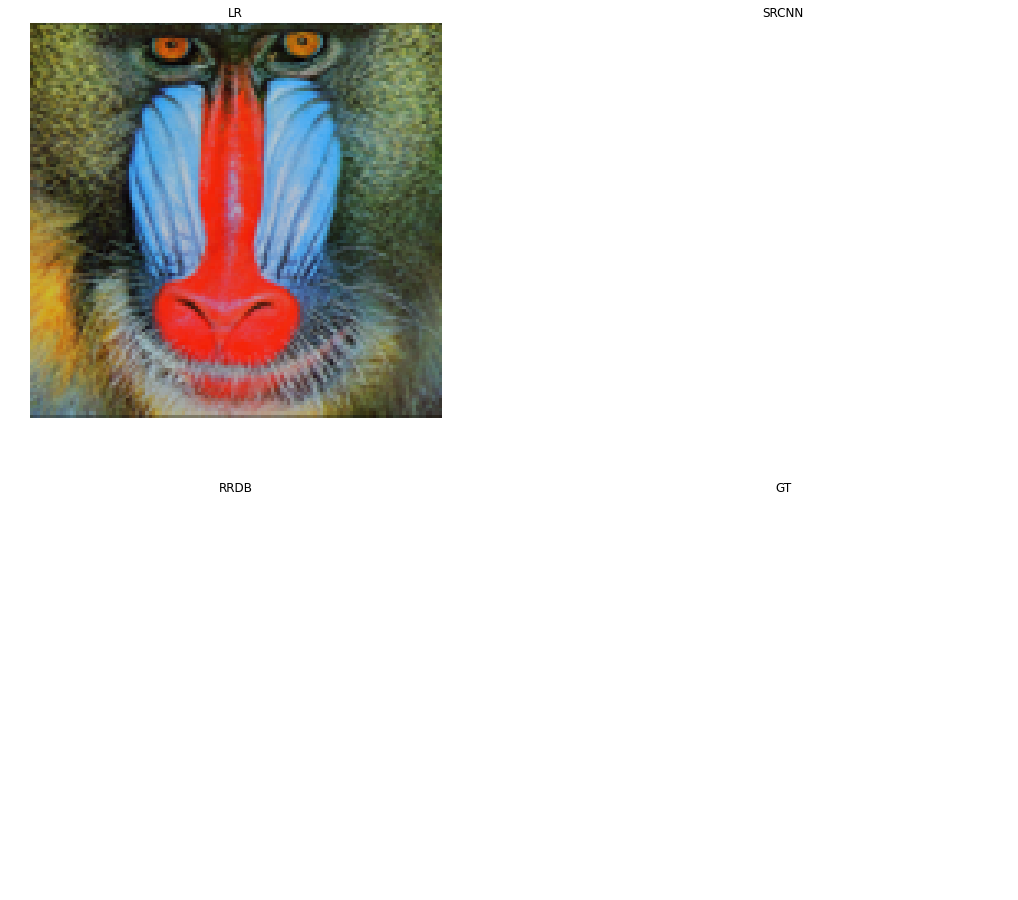

In [11]:
%matplotlib inline
import mmcv
import matplotlib.pyplot as plt

# Load LR and GT images 
img_lr = mmcv.imread('./data/baboon_x4.png', channel_order='rgb') # read LR_image
img_gt = mmcv.imread('./data/baboon.png', channel_order='rgb') # read GT (Ground-Truth) image

# Load SRCNN and RRDB-Net results 
# img_srcnn = mmcv.imread('./results/baboon_SRCNN.png', channel_order='rgb') # 之前跑SRCNN的结果
img_rrdb_net = mmcv.imread('./results/baboon_RRDB-Net.png', channel_order='rgb')

# Plot figures 
fig = plt.figure(figsize=(18,16))
ax1 = fig.add_subplot(2,2,1) # 2 rows, 2 columns, the top left image
ax1.title.set_text('LR')
ax1.axis('off')

ax2 = fig.add_subplot(2,2,2) # 2 rows, 2 columns, the top right image
ax2.title.set_text('SRCNN')
ax2.axis('off')

ax3 = fig.add_subplot(2,2,3) # 2 rows, 2 columns, the bottom left image
ax3.title.set_text('RRDB')
ax3.axis('off')

ax4 = fig.add_subplot(2,2,4) # 2 rows, 2 columns, the botteom right image
ax4.title.set_text('GT')
ax4.axis('off')

ax1.imshow(img_lr)
# ax2.imshow(img_srcnn)
ax3.imshow(img_rrdb_net)
ax4.imshow(img_gt)

The top left is the input low-resolution image. The top right is the SRCNN output. The bottom left is the larger RRDB-Net result, while the bottom right is the ground truth. 

These results suggests that we can recover better results with sharper edges by using a model with a higher capacity and improved structure. 

However, even thought the output of RRDB-Net has sharper edges thatn that of SRCNN, the texture of the baboon is till unstatisfactory compared to the ground truth, especially the whiskers.

For human beings, we prefer outputs with higher perceptual quality more than PSNR-oriented outputs.

## Perceptual Quality 

Let's try ESRGAN for better perceptual quality.

The network structure is the same as that of RRDB-net. However, it is trained with [GAN loss](https://arxiv.org/abs/1609.04802) and [perceptual loss](https://arxiv.org/abs/1603.08155). 

2022-03-28 14:05:02,642 - mmedit - INFO - load checkpoint from torchvision path: torchvision://vgg19
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

load checkpoint from local path: checkpoints/esrgan_x4c64b23g32_1x16_400k_div2k_20200508-f8ccaf3b.pth


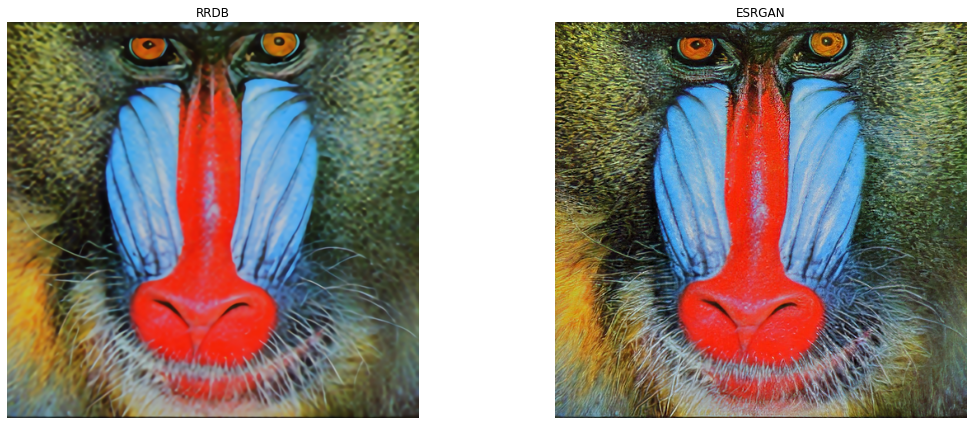

In [23]:
# Configuations 
config = 'configs/restorers/esrgan/esrgan_x4c64b23g32_g1_400k_div2k.py'
checkpoint = 'checkpoints/esrgan_x4c64b23g32_1x16_400k_div2k_20200508-f8ccaf3b.pth'
img_path = 'data/baboon_x4.png'
save_path = 'results/baboon_ESRGAN.png'

# Initialize model 
model = init_model(
    config, checkpoint, device=torch.device('cuda'))
# Inference
output = restoration_inference(model, img_path)
output = tensor2img(output)

mmcv.imwrite(output, save_path)

# Visualize 
img_esrgan = mmcv.imread('results/baboon_ESRGAN.png', channel_order='rgb')

fig = plt.figure(figsize=(18, 16))
ax1 = fig.add_subplot(2, 2, 1)
ax1.title.set_text('RRDB')
ax1.axis('off')
ax2 = fig.add_subplot(2, 2, 2)
ax2.title.set_text('ESRGAN')
ax2.axis('off')

ax1.imshow(img_rrdb_net)
ax2.imshow(img_esrgan)

Compare the picture on the left and on the right. Is the new outcome much improve? This is the magic of generative adversarial network and perceptual loss!

## Metrics 
Usually we use some metrics to measure the image quality after super-resolution. Here we introduce two metrics: PSNR and NIQE.

## PSNR(Peak Signal-to_Noise Ratio)
We usually measure the output with Peak Signal-to-Noise Ratio, often abbreviated PSNR. It is an engineering term for the ratio between the maximum possible pwoer of a signal and the power of corrupting noise that affects the fidelity of its representation. 

The formulation is as follows: Given a mxn image I and its approximation K, MSE is defiend as:
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/3a34719b4f391dba26b3e8e4460b7595d62eece4)

The PSNR (in dB) is defined as:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/fc22801ed1232ff1231c4156b589de5c32063a8a)

Here, MAX is the maximum possible pixel value of the image. When the pixels are represented using 8 bits per sample, this is 255. 


We can calculate the PSNR of each image using MMEditing metric functions

In [25]:
from mmedit.core.evaluation import psnr, niqe 
# Bicublic images 
h, w, c = img_lr.shape
img_bic, _, _ = mmcv.imresize(img_lr, (w * 4, h*4), 'bicublic')
psnr_bic = psnr(img_bic, img_gt, crop_border=4, input_order='HWC')
print('PSNR for bicubic image: ', psnr_bic)

PSNR for bicubic image:  20.219525478550597


In [31]:
# PSNRs for SRCNN and RRDB-Net 
# psnr_srcnn = psnr(img_srcnn, img_gt, crop_border=4, input_order='HWC')
psnr_rrdb_net = psnr(img_rrdb_net, img_gt, crop_border=4, input_order='HWC')
psnr_esrgan = psnr(img_esrgan, img_gt, crop_border=4, input_order='HWC')
# print('PSNR for SRCNN image: ', psnr_srcnn)
print('PSNR for RRDB-Net image: ', psnr_rrdb_net)
print('PSNR for ESRGAN: ', psnr_esrgan)

PSNR for RRDB-Net image:  21.073739904832536
PSNR for ESRGAN:  18.613523297872547


We can see that RRDB-Net output has a higher PSNR than SRCNN output. Interestingly, the PSNR of ESRGAN output is lower than that of RRDB-Net and SRCNN output, even though ESRGAN has a more visual-pleasing effect.

So, PSNR is not a good metric for reflecting the perceptual quality.

Therefore, we introduce another metric that is able to reflect the perceptual quality of super-resolution - NIQE.

## NIQE (Natural Image Quality Evaluator)
NIQE is a no-reference image quality evaluator that assesses image quality without knowledge of anticipated distortions or human opinions of them. The quality of the distorted image is expressed as a simple distance metric between the model statistics and those of the distorted image. Such a model has great potential to be applied in unconstrined environments.

Paper: [Making a "Completely Blind" Image Quality Analyzer](http://live.ece.utexas.edu/research/Quality/niqe_spl.pdf)

We can also call NIQE functions using MMEditing APIs. 

In [29]:
# Calculate NIQE of ESGAN
niqe_bic = niqe(img_bic, crop_border=4, input_order='HWC')
# niqe_srcnn = niqe(img_srcnn, crop_border=4, input_order='HWC')
niqe_rreb_net = niqe(img_rrdb_net, crop_border=4, input_order='HWC')
niqe_esrgan = niqe(img_esrgan, crop_border=4, input_order='HWC')
niqe_gt = niqe(img_gt, crop_border=4, input_order='HWC')

print('NIQE for bicubic image: ', niqe_bic)
# print('NIQE for SRCNN image: ', niqe_srcnn)
print('NIQE for RRDB-Net image: ', niqe_rreb_net)
print('NIQE for ESRGAN image: ', niqe_esrgan)
print('NIQE for GT image: ', niqe_gt)

NIQE for bicubic image:  10.670614001608506
NIQE for RRDB-Net image:  4.902968940932384
NIQE for ESRGAN image:  2.998182733688933
NIQE for GT image:  6.06682951464115


The ESRGAN result could produce lower NIQE, indicating better visual quality.

However, this metric is also not perfect. From the above values, we can also see that the GT image has a higher NIQE value than outputs of RRDB-Net and ESRGAN, which is not reasonable.

## Try it Yourself!
You can use other images from the dataset and super-resolve them~

In [32]:
# Inference with SRCNN
! python demo/restoration_demo.py configs/restorers/srcnn/srcnn_x4k915_g1_1000k_div2k.py checkpoints/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth data/zebra_x4.png results/zebra_SRCNN.png
# Inference with RRDB-Net
! python demo/restoration_demo.py configs/restorers/esrgan/esrgan_psnr_x4c64b23g32_g1_1000k_div2k.py checkpoints/esrgan_psnr_x4c64b23g32_1x16_1000k_div2k_20200420-bf5c993c.pth data/zebra_x4.png results/zebra_RRDB-Net.png
# Inference with ESRGAN
! python demo/restoration_demo.py configs/restorers/esrgan/esrgan_x4c64b23g32_g1_400k_div2k.py checkpoints/esrgan_x4c64b23g32_1x16_400k_div2k_20200508-f8ccaf3b.pth data/zebra_x4.png results/zebra_ESRGAN.png

Traceback (most recent call last):
  File "demo/restoration_demo.py", line 58, in <module>
    main()
  File "demo/restoration_demo.py", line 32, in main
    if not os.path.isfile(args.img_path):
AttributeError: 'Namespace' object has no attribute 'img_path'
Traceback (most recent call last):
  File "demo/restoration_demo.py", line 58, in <module>
    main()
  File "demo/restoration_demo.py", line 32, in main
    if not os.path.isfile(args.img_path):
AttributeError: 'Namespace' object has no attribute 'img_path'
Traceback (most recent call last):
  File "demo/restoration_demo.py", line 58, in <module>
    main()
  File "demo/restoration_demo.py", line 32, in main
    if not os.path.isfile(args.img_path):
AttributeError: 'Namespace' object has no attribute 'img_path'


In [ ]:
# Load LR and GT images
zebra_lr = mmcv.imread('./data/zebra_x4.png', channel_order='rgb')  # read GT (Ground-Truth) image
# Load SRCNN and RRDB-Net results
zebra_srcnn = mmcv.imread('./results/zebra_SRCNN.png', channel_order='rgb')
zebra_rrdb_net = mmcv.imread('./results/zebra_RRDB-Net.png', channel_order='rgb')
# Load ESRGAN result
zebra_esrgan = mmcv.imread('./results/zebra_ESRGAN.png', channel_order='rgb')

# Plot figures
fig = plt.figure(figsize=(18, 16))
ax1 = fig.add_subplot(2, 2, 1)  # 2 rows, 2 columns, the top left image  
ax1.axis('off')
ax2 = fig.add_subplot(2, 2, 2)  # 2 rows, 2 columns, the top right image  
ax2.axis('off')
ax3 = fig.add_subplot(2, 2, 3)  # 2 rows, 2 columns, the top right image  
ax3.axis('off')
ax4 = fig.add_subplot(2, 2, 4)  # 2 rows, 2 columns, the bottom right image  
ax4.axis('off')
ax1.imshow(zebra_lr)
ax2.imshow(zebra_srcnn)
ax3.imshow(zebra_rrdb_net)
ax4.imshow(zebra_esrgan)

## Balance PSNR-oriented REsults and Perceptual Quality

How to balance the PSNR-oriented results and GAN effects to meet various user favors and application scenarios?

We introduce a simple yet effective technique to achieve this goal - Deep Network Interpolation. (DNI)

It actually interplotes two networks in thier parameter space!

Sounds crazy? Let's look at what is does!

This is the illustration of Deep Network Interpolation (DNI). 
Provided with a model for a particular effect A, we fine-tune it to realize another relevant effect B. 
DNI applies linear interpolation for all the corresponding parameters of these two deep networks.
Various interpolated models can then be derived by a controllable interpolation coefficient. 
Performing feed-forward operations on these interpolated models using the same input allows us to produce output with a continuous transition between the different effects A and B. 

![](https://raw.githubusercontent.com/xinntao/public-figures/master/MMEditing-Tutorial/DNI_1.jpg)

![](https://raw.githubusercontent.com/xinntao/public-figures/master/MMEditing-Tutorial/DNI_2.jpg)

Let's first look at the parameters of the network.

In [33]:
import torch
net_rrdb_net = torch.load('checkpoints/esrgan_psnr_x4c64b23g32_1x16_1000k_div2k_20200420-bf5c993c.pth')

for key, value in net_rrdb_net['state_dict'].items():
    print(key)

generator.conv_first.weight
generator.conv_first.bias
generator.body.0.rdb1.conv1.weight
generator.body.0.rdb1.conv1.bias
generator.body.0.rdb1.conv2.weight
generator.body.0.rdb1.conv2.bias
generator.body.0.rdb1.conv3.weight
generator.body.0.rdb1.conv3.bias
generator.body.0.rdb1.conv4.weight
generator.body.0.rdb1.conv4.bias
generator.body.0.rdb1.conv5.weight
generator.body.0.rdb1.conv5.bias
generator.body.0.rdb2.conv1.weight
generator.body.0.rdb2.conv1.bias
generator.body.0.rdb2.conv2.weight
generator.body.0.rdb2.conv2.bias
generator.body.0.rdb2.conv3.weight
generator.body.0.rdb2.conv3.bias
generator.body.0.rdb2.conv4.weight
generator.body.0.rdb2.conv4.bias
generator.body.0.rdb2.conv5.weight
generator.body.0.rdb2.conv5.bias
generator.body.0.rdb3.conv1.weight
generator.body.0.rdb3.conv1.bias
generator.body.0.rdb3.conv2.weight
generator.body.0.rdb3.conv2.bias
generator.body.0.rdb3.conv3.weight
generator.body.0.rdb3.conv3.bias
generator.body.0.rdb3.conv4.weight
generator.body.0.rdb3.conv4

Interpolate with coefficient 0.8

It merely performs a linear combination on the two network parameters.

In [35]:
net_esrgan = torch.load('checkpoints/esrgan_x4c64b23g32_1x16_400k_div2k_20200508-f8ccaf3b.pth')
alpha = 0.8
interpolated_net = {'meta': f'interpolated network with alpha {alpha}','state_dict': dict()}
for key, value in net_rrdb_net['state_dict'].items():
    interpolated_net['state_dict'][key] = alpha * net_rrdb_net['state_dict'][key] + (1-alpha) * net_esrgan['state_dict'][key]

torch.save(interpolated_net, './interpolated_net.pth')

## Inference with the interpolated network

2022-03-28 15:02:30,973 - mmedit - INFO - load checkpoint from torchvision path: torchvision://vgg19


load checkpoint from local path: interpolated_net.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: discriminator.conv0_0.weight, discriminator.conv0_0.bias, discriminator.conv0_1.weight, discriminator.bn0_1.weight, discriminator.bn0_1.bias, discriminator.bn0_1.running_mean, discriminator.bn0_1.running_var, discriminator.conv1_0.weight, discriminator.bn1_0.weight, discriminator.bn1_0.bias, discriminator.bn1_0.running_mean, discriminator.bn1_0.running_var, discriminator.conv1_1.weight, discriminator.bn1_1.weight, discriminator.bn1_1.bias, discriminator.bn1_1.running_mean, discriminator.bn1_1.running_var, discriminator.conv2_0.weight, discriminator.bn2_0.weight, discriminator.bn2_0.bias, discriminator.bn2_0.running_mean, discriminator.bn2_0.running_var, discriminator.conv2_1.weight, discriminator.bn2_1.weight, discriminator.bn2_1.bias, discriminator.bn2_1.running_mean, discriminator.bn2_1.running_var, discriminator.conv3_0.weight, discriminator.

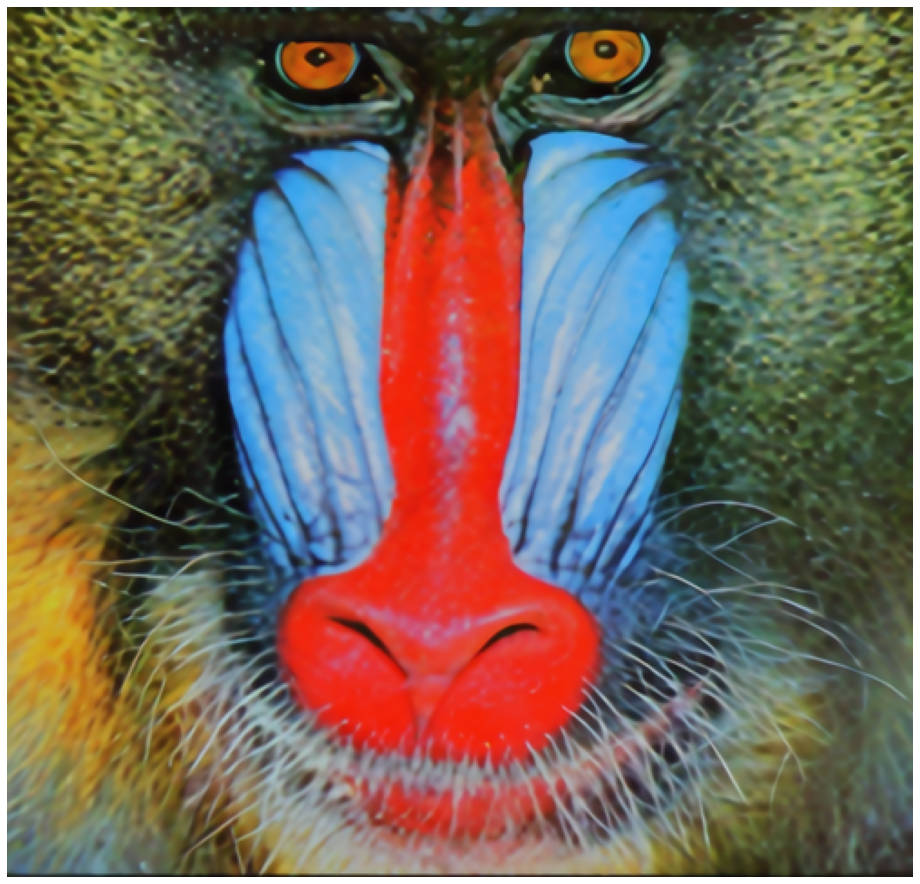

In [37]:
config = 'configs/restorers/esrgan/esrgan_x4c64b23g32_g1_400k_div2k.py'
checkpoint = 'interpolated_net.pth'
img_path = 'data/baboon_x4.png'
save_path = 'results/baboon_ESRGAN_interpolated.png'

model = init_model(
        config, checkpoint, device=torch.device('cuda'))

output = restoration_inference(model, img_path)
output = tensor2img(output)

mmcv.imwrite(output, save_path)

# visualize 
img_interp = mmcv.imread('results/baboon_ESRGAN_interpolated.png', channel_order='rgb')

fig = plt.figure(figsize=(18, 16))
ax1 = fig.add_subplot(1, 1, 1)
ax1.axis('off')
ax1.imshow(img_interp)

Cannot see the difference? Now let's do some fancy work!

Let's interpolate between two networks with an interval of 0.05.

In [38]:
import numpy as np
for alpha in list(np.arange(0, 1.05, 0.05)):
    print(f'Interpolating with alpha = {alpha:.2f}...')
    interpolated_net = {'meta':f'interpolated network with alpha {alpha}', 'state_dict':dict()}
    for key, value in net_rrdb_net['state_dict'].items():
        interpolated_net['state_dict'][key] = alpha * net_rrdb_net['state_dict'][key] + (1-alpha) * net_esrgan['state_dict'][key]
    torch.save(interpolated_net, f'./interpolated_net_{int(alpha*100):03d}.pth')

Interpolating with alpha = 0.00...
Interpolating with alpha = 0.05...
Interpolating with alpha = 0.10...
Interpolating with alpha = 0.15...
Interpolating with alpha = 0.20...
Interpolating with alpha = 0.25...
Interpolating with alpha = 0.30...
Interpolating with alpha = 0.35...
Interpolating with alpha = 0.40...
Interpolating with alpha = 0.45...
Interpolating with alpha = 0.50...
Interpolating with alpha = 0.55...
Interpolating with alpha = 0.60...
Interpolating with alpha = 0.65...
Interpolating with alpha = 0.70...
Interpolating with alpha = 0.75...
Interpolating with alpha = 0.80...
Interpolating with alpha = 0.85...
Interpolating with alpha = 0.90...
Interpolating with alpha = 0.95...
Interpolating with alpha = 1.00...


In [39]:
import mmcv
import torch
from mmedit.apis import init_model, restoration_inference
from mmedit.core import tensor2img

config = 'configs/restorers/esrgan/esrgan_x4c64b23g32_g1_400k_div2k.py'
img_path = 'data/baboon_x4.png'
for alpha in list(np.arange(0, 1.05, 0.05)):
    checkpoint = f'./interpolated_net_{int(alpha*100):03d}.pth'
    print(f'Inference with {checkpoint}...')
    save_path = f'results/baboon_interpolated_{int(alpha*100):03d}.png'

    model  = init_model(
            config, checkpoint, device=torch.device('cuda'))
    
    output = restoration_inference(model, img_path)
    output = tensor2img(output)

    mmcv.imwrite(output, save_path)

    

Inference with ./interpolated_net_000.pth...


2022-03-28 15:12:40,206 - mmedit - INFO - load checkpoint from torchvision path: torchvision://vgg19


load checkpoint from local path: ./interpolated_net_000.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: discriminator.conv0_0.weight, discriminator.conv0_0.bias, discriminator.conv0_1.weight, discriminator.bn0_1.weight, discriminator.bn0_1.bias, discriminator.bn0_1.running_mean, discriminator.bn0_1.running_var, discriminator.conv1_0.weight, discriminator.bn1_0.weight, discriminator.bn1_0.bias, discriminator.bn1_0.running_mean, discriminator.bn1_0.running_var, discriminator.conv1_1.weight, discriminator.bn1_1.weight, discriminator.bn1_1.bias, discriminator.bn1_1.running_mean, discriminator.bn1_1.running_var, discriminator.conv2_0.weight, discriminator.bn2_0.weight, discriminator.bn2_0.bias, discriminator.bn2_0.running_mean, discriminator.bn2_0.running_var, discriminator.conv2_1.weight, discriminator.bn2_1.weight, discriminator.bn2_1.bias, discriminator.bn2_1.running_mean, discriminator.bn2_1.running_var, discriminator.conv3_0.weight, discrimi

2022-03-28 15:12:43,453 - mmedit - INFO - load checkpoint from torchvision path: torchvision://vgg19


load checkpoint from local path: ./interpolated_net_005.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: discriminator.conv0_0.weight, discriminator.conv0_0.bias, discriminator.conv0_1.weight, discriminator.bn0_1.weight, discriminator.bn0_1.bias, discriminator.bn0_1.running_mean, discriminator.bn0_1.running_var, discriminator.conv1_0.weight, discriminator.bn1_0.weight, discriminator.bn1_0.bias, discriminator.bn1_0.running_mean, discriminator.bn1_0.running_var, discriminator.conv1_1.weight, discriminator.bn1_1.weight, discriminator.bn1_1.bias, discriminator.bn1_1.running_mean, discriminator.bn1_1.running_var, discriminator.conv2_0.weight, discriminator.bn2_0.weight, discriminator.bn2_0.bias, discriminator.bn2_0.running_mean, discriminator.bn2_0.running_var, discriminator.conv2_1.weight, discriminator.bn2_1.weight, discriminator.bn2_1.bias, discriminator.bn2_1.running_mean, discriminator.bn2_1.running_var, discriminator.conv3_0.weight, discrimi

2022-03-28 15:12:46,390 - mmedit - INFO - load checkpoint from torchvision path: torchvision://vgg19


load checkpoint from local path: ./interpolated_net_010.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: discriminator.conv0_0.weight, discriminator.conv0_0.bias, discriminator.conv0_1.weight, discriminator.bn0_1.weight, discriminator.bn0_1.bias, discriminator.bn0_1.running_mean, discriminator.bn0_1.running_var, discriminator.conv1_0.weight, discriminator.bn1_0.weight, discriminator.bn1_0.bias, discriminator.bn1_0.running_mean, discriminator.bn1_0.running_var, discriminator.conv1_1.weight, discriminator.bn1_1.weight, discriminator.bn1_1.bias, discriminator.bn1_1.running_mean, discriminator.bn1_1.running_var, discriminator.conv2_0.weight, discriminator.bn2_0.weight, discriminator.bn2_0.bias, discriminator.bn2_0.running_mean, discriminator.bn2_0.running_var, discriminator.conv2_1.weight, discriminator.bn2_1.weight, discriminator.bn2_1.bias, discriminator.bn2_1.running_mean, discriminator.bn2_1.running_var, discriminator.conv3_0.weight, discrimi

2022-03-28 15:12:49,319 - mmedit - INFO - load checkpoint from torchvision path: torchvision://vgg19


load checkpoint from local path: ./interpolated_net_015.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: discriminator.conv0_0.weight, discriminator.conv0_0.bias, discriminator.conv0_1.weight, discriminator.bn0_1.weight, discriminator.bn0_1.bias, discriminator.bn0_1.running_mean, discriminator.bn0_1.running_var, discriminator.conv1_0.weight, discriminator.bn1_0.weight, discriminator.bn1_0.bias, discriminator.bn1_0.running_mean, discriminator.bn1_0.running_var, discriminator.conv1_1.weight, discriminator.bn1_1.weight, discriminator.bn1_1.bias, discriminator.bn1_1.running_mean, discriminator.bn1_1.running_var, discriminator.conv2_0.weight, discriminator.bn2_0.weight, discriminator.bn2_0.bias, discriminator.bn2_0.running_mean, discriminator.bn2_0.running_var, discriminator.conv2_1.weight, discriminator.bn2_1.weight, discriminator.bn2_1.bias, discriminator.bn2_1.running_mean, discriminator.bn2_1.running_var, discriminator.conv3_0.weight, discrimi

2022-03-28 15:12:52,273 - mmedit - INFO - load checkpoint from torchvision path: torchvision://vgg19


load checkpoint from local path: ./interpolated_net_020.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: discriminator.conv0_0.weight, discriminator.conv0_0.bias, discriminator.conv0_1.weight, discriminator.bn0_1.weight, discriminator.bn0_1.bias, discriminator.bn0_1.running_mean, discriminator.bn0_1.running_var, discriminator.conv1_0.weight, discriminator.bn1_0.weight, discriminator.bn1_0.bias, discriminator.bn1_0.running_mean, discriminator.bn1_0.running_var, discriminator.conv1_1.weight, discriminator.bn1_1.weight, discriminator.bn1_1.bias, discriminator.bn1_1.running_mean, discriminator.bn1_1.running_var, discriminator.conv2_0.weight, discriminator.bn2_0.weight, discriminator.bn2_0.bias, discriminator.bn2_0.running_mean, discriminator.bn2_0.running_var, discriminator.conv2_1.weight, discriminator.bn2_1.weight, discriminator.bn2_1.bias, discriminator.bn2_1.running_mean, discriminator.bn2_1.running_var, discriminator.conv3_0.weight, discrimi

2022-03-28 15:12:55,178 - mmedit - INFO - load checkpoint from torchvision path: torchvision://vgg19


load checkpoint from local path: ./interpolated_net_025.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: discriminator.conv0_0.weight, discriminator.conv0_0.bias, discriminator.conv0_1.weight, discriminator.bn0_1.weight, discriminator.bn0_1.bias, discriminator.bn0_1.running_mean, discriminator.bn0_1.running_var, discriminator.conv1_0.weight, discriminator.bn1_0.weight, discriminator.bn1_0.bias, discriminator.bn1_0.running_mean, discriminator.bn1_0.running_var, discriminator.conv1_1.weight, discriminator.bn1_1.weight, discriminator.bn1_1.bias, discriminator.bn1_1.running_mean, discriminator.bn1_1.running_var, discriminator.conv2_0.weight, discriminator.bn2_0.weight, discriminator.bn2_0.bias, discriminator.bn2_0.running_mean, discriminator.bn2_0.running_var, discriminator.conv2_1.weight, discriminator.bn2_1.weight, discriminator.bn2_1.bias, discriminator.bn2_1.running_mean, discriminator.bn2_1.running_var, discriminator.conv3_0.weight, discrimi

2022-03-28 15:12:58,096 - mmedit - INFO - load checkpoint from torchvision path: torchvision://vgg19


load checkpoint from local path: ./interpolated_net_030.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: discriminator.conv0_0.weight, discriminator.conv0_0.bias, discriminator.conv0_1.weight, discriminator.bn0_1.weight, discriminator.bn0_1.bias, discriminator.bn0_1.running_mean, discriminator.bn0_1.running_var, discriminator.conv1_0.weight, discriminator.bn1_0.weight, discriminator.bn1_0.bias, discriminator.bn1_0.running_mean, discriminator.bn1_0.running_var, discriminator.conv1_1.weight, discriminator.bn1_1.weight, discriminator.bn1_1.bias, discriminator.bn1_1.running_mean, discriminator.bn1_1.running_var, discriminator.conv2_0.weight, discriminator.bn2_0.weight, discriminator.bn2_0.bias, discriminator.bn2_0.running_mean, discriminator.bn2_0.running_var, discriminator.conv2_1.weight, discriminator.bn2_1.weight, discriminator.bn2_1.bias, discriminator.bn2_1.running_mean, discriminator.bn2_1.running_var, discriminator.conv3_0.weight, discrimi

2022-03-28 15:13:00,947 - mmedit - INFO - load checkpoint from torchvision path: torchvision://vgg19


load checkpoint from local path: ./interpolated_net_035.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: discriminator.conv0_0.weight, discriminator.conv0_0.bias, discriminator.conv0_1.weight, discriminator.bn0_1.weight, discriminator.bn0_1.bias, discriminator.bn0_1.running_mean, discriminator.bn0_1.running_var, discriminator.conv1_0.weight, discriminator.bn1_0.weight, discriminator.bn1_0.bias, discriminator.bn1_0.running_mean, discriminator.bn1_0.running_var, discriminator.conv1_1.weight, discriminator.bn1_1.weight, discriminator.bn1_1.bias, discriminator.bn1_1.running_mean, discriminator.bn1_1.running_var, discriminator.conv2_0.weight, discriminator.bn2_0.weight, discriminator.bn2_0.bias, discriminator.bn2_0.running_mean, discriminator.bn2_0.running_var, discriminator.conv2_1.weight, discriminator.bn2_1.weight, discriminator.bn2_1.bias, discriminator.bn2_1.running_mean, discriminator.bn2_1.running_var, discriminator.conv3_0.weight, discrimi

2022-03-28 15:13:03,832 - mmedit - INFO - load checkpoint from torchvision path: torchvision://vgg19


load checkpoint from local path: ./interpolated_net_040.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: discriminator.conv0_0.weight, discriminator.conv0_0.bias, discriminator.conv0_1.weight, discriminator.bn0_1.weight, discriminator.bn0_1.bias, discriminator.bn0_1.running_mean, discriminator.bn0_1.running_var, discriminator.conv1_0.weight, discriminator.bn1_0.weight, discriminator.bn1_0.bias, discriminator.bn1_0.running_mean, discriminator.bn1_0.running_var, discriminator.conv1_1.weight, discriminator.bn1_1.weight, discriminator.bn1_1.bias, discriminator.bn1_1.running_mean, discriminator.bn1_1.running_var, discriminator.conv2_0.weight, discriminator.bn2_0.weight, discriminator.bn2_0.bias, discriminator.bn2_0.running_mean, discriminator.bn2_0.running_var, discriminator.conv2_1.weight, discriminator.bn2_1.weight, discriminator.bn2_1.bias, discriminator.bn2_1.running_mean, discriminator.bn2_1.running_var, discriminator.conv3_0.weight, discrimi

2022-03-28 15:13:06,840 - mmedit - INFO - load checkpoint from torchvision path: torchvision://vgg19


load checkpoint from local path: ./interpolated_net_045.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: discriminator.conv0_0.weight, discriminator.conv0_0.bias, discriminator.conv0_1.weight, discriminator.bn0_1.weight, discriminator.bn0_1.bias, discriminator.bn0_1.running_mean, discriminator.bn0_1.running_var, discriminator.conv1_0.weight, discriminator.bn1_0.weight, discriminator.bn1_0.bias, discriminator.bn1_0.running_mean, discriminator.bn1_0.running_var, discriminator.conv1_1.weight, discriminator.bn1_1.weight, discriminator.bn1_1.bias, discriminator.bn1_1.running_mean, discriminator.bn1_1.running_var, discriminator.conv2_0.weight, discriminator.bn2_0.weight, discriminator.bn2_0.bias, discriminator.bn2_0.running_mean, discriminator.bn2_0.running_var, discriminator.conv2_1.weight, discriminator.bn2_1.weight, discriminator.bn2_1.bias, discriminator.bn2_1.running_mean, discriminator.bn2_1.running_var, discriminator.conv3_0.weight, discrimi

2022-03-28 15:13:09,771 - mmedit - INFO - load checkpoint from torchvision path: torchvision://vgg19


load checkpoint from local path: ./interpolated_net_050.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: discriminator.conv0_0.weight, discriminator.conv0_0.bias, discriminator.conv0_1.weight, discriminator.bn0_1.weight, discriminator.bn0_1.bias, discriminator.bn0_1.running_mean, discriminator.bn0_1.running_var, discriminator.conv1_0.weight, discriminator.bn1_0.weight, discriminator.bn1_0.bias, discriminator.bn1_0.running_mean, discriminator.bn1_0.running_var, discriminator.conv1_1.weight, discriminator.bn1_1.weight, discriminator.bn1_1.bias, discriminator.bn1_1.running_mean, discriminator.bn1_1.running_var, discriminator.conv2_0.weight, discriminator.bn2_0.weight, discriminator.bn2_0.bias, discriminator.bn2_0.running_mean, discriminator.bn2_0.running_var, discriminator.conv2_1.weight, discriminator.bn2_1.weight, discriminator.bn2_1.bias, discriminator.bn2_1.running_mean, discriminator.bn2_1.running_var, discriminator.conv3_0.weight, discrimi

2022-03-28 15:13:12,650 - mmedit - INFO - load checkpoint from torchvision path: torchvision://vgg19


load checkpoint from local path: ./interpolated_net_055.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: discriminator.conv0_0.weight, discriminator.conv0_0.bias, discriminator.conv0_1.weight, discriminator.bn0_1.weight, discriminator.bn0_1.bias, discriminator.bn0_1.running_mean, discriminator.bn0_1.running_var, discriminator.conv1_0.weight, discriminator.bn1_0.weight, discriminator.bn1_0.bias, discriminator.bn1_0.running_mean, discriminator.bn1_0.running_var, discriminator.conv1_1.weight, discriminator.bn1_1.weight, discriminator.bn1_1.bias, discriminator.bn1_1.running_mean, discriminator.bn1_1.running_var, discriminator.conv2_0.weight, discriminator.bn2_0.weight, discriminator.bn2_0.bias, discriminator.bn2_0.running_mean, discriminator.bn2_0.running_var, discriminator.conv2_1.weight, discriminator.bn2_1.weight, discriminator.bn2_1.bias, discriminator.bn2_1.running_mean, discriminator.bn2_1.running_var, discriminator.conv3_0.weight, discrimi

2022-03-28 15:13:15,555 - mmedit - INFO - load checkpoint from torchvision path: torchvision://vgg19


load checkpoint from local path: ./interpolated_net_060.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: discriminator.conv0_0.weight, discriminator.conv0_0.bias, discriminator.conv0_1.weight, discriminator.bn0_1.weight, discriminator.bn0_1.bias, discriminator.bn0_1.running_mean, discriminator.bn0_1.running_var, discriminator.conv1_0.weight, discriminator.bn1_0.weight, discriminator.bn1_0.bias, discriminator.bn1_0.running_mean, discriminator.bn1_0.running_var, discriminator.conv1_1.weight, discriminator.bn1_1.weight, discriminator.bn1_1.bias, discriminator.bn1_1.running_mean, discriminator.bn1_1.running_var, discriminator.conv2_0.weight, discriminator.bn2_0.weight, discriminator.bn2_0.bias, discriminator.bn2_0.running_mean, discriminator.bn2_0.running_var, discriminator.conv2_1.weight, discriminator.bn2_1.weight, discriminator.bn2_1.bias, discriminator.bn2_1.running_mean, discriminator.bn2_1.running_var, discriminator.conv3_0.weight, discrimi

2022-03-28 15:13:18,425 - mmedit - INFO - load checkpoint from torchvision path: torchvision://vgg19


load checkpoint from local path: ./interpolated_net_065.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: discriminator.conv0_0.weight, discriminator.conv0_0.bias, discriminator.conv0_1.weight, discriminator.bn0_1.weight, discriminator.bn0_1.bias, discriminator.bn0_1.running_mean, discriminator.bn0_1.running_var, discriminator.conv1_0.weight, discriminator.bn1_0.weight, discriminator.bn1_0.bias, discriminator.bn1_0.running_mean, discriminator.bn1_0.running_var, discriminator.conv1_1.weight, discriminator.bn1_1.weight, discriminator.bn1_1.bias, discriminator.bn1_1.running_mean, discriminator.bn1_1.running_var, discriminator.conv2_0.weight, discriminator.bn2_0.weight, discriminator.bn2_0.bias, discriminator.bn2_0.running_mean, discriminator.bn2_0.running_var, discriminator.conv2_1.weight, discriminator.bn2_1.weight, discriminator.bn2_1.bias, discriminator.bn2_1.running_mean, discriminator.bn2_1.running_var, discriminator.conv3_0.weight, discrimi

2022-03-28 15:13:21,411 - mmedit - INFO - load checkpoint from torchvision path: torchvision://vgg19


load checkpoint from local path: ./interpolated_net_070.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: discriminator.conv0_0.weight, discriminator.conv0_0.bias, discriminator.conv0_1.weight, discriminator.bn0_1.weight, discriminator.bn0_1.bias, discriminator.bn0_1.running_mean, discriminator.bn0_1.running_var, discriminator.conv1_0.weight, discriminator.bn1_0.weight, discriminator.bn1_0.bias, discriminator.bn1_0.running_mean, discriminator.bn1_0.running_var, discriminator.conv1_1.weight, discriminator.bn1_1.weight, discriminator.bn1_1.bias, discriminator.bn1_1.running_mean, discriminator.bn1_1.running_var, discriminator.conv2_0.weight, discriminator.bn2_0.weight, discriminator.bn2_0.bias, discriminator.bn2_0.running_mean, discriminator.bn2_0.running_var, discriminator.conv2_1.weight, discriminator.bn2_1.weight, discriminator.bn2_1.bias, discriminator.bn2_1.running_mean, discriminator.bn2_1.running_var, discriminator.conv3_0.weight, discrimi

2022-03-28 15:13:24,406 - mmedit - INFO - load checkpoint from torchvision path: torchvision://vgg19


load checkpoint from local path: ./interpolated_net_075.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: discriminator.conv0_0.weight, discriminator.conv0_0.bias, discriminator.conv0_1.weight, discriminator.bn0_1.weight, discriminator.bn0_1.bias, discriminator.bn0_1.running_mean, discriminator.bn0_1.running_var, discriminator.conv1_0.weight, discriminator.bn1_0.weight, discriminator.bn1_0.bias, discriminator.bn1_0.running_mean, discriminator.bn1_0.running_var, discriminator.conv1_1.weight, discriminator.bn1_1.weight, discriminator.bn1_1.bias, discriminator.bn1_1.running_mean, discriminator.bn1_1.running_var, discriminator.conv2_0.weight, discriminator.bn2_0.weight, discriminator.bn2_0.bias, discriminator.bn2_0.running_mean, discriminator.bn2_0.running_var, discriminator.conv2_1.weight, discriminator.bn2_1.weight, discriminator.bn2_1.bias, discriminator.bn2_1.running_mean, discriminator.bn2_1.running_var, discriminator.conv3_0.weight, discrimi

2022-03-28 15:13:27,476 - mmedit - INFO - load checkpoint from torchvision path: torchvision://vgg19


load checkpoint from local path: ./interpolated_net_080.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: discriminator.conv0_0.weight, discriminator.conv0_0.bias, discriminator.conv0_1.weight, discriminator.bn0_1.weight, discriminator.bn0_1.bias, discriminator.bn0_1.running_mean, discriminator.bn0_1.running_var, discriminator.conv1_0.weight, discriminator.bn1_0.weight, discriminator.bn1_0.bias, discriminator.bn1_0.running_mean, discriminator.bn1_0.running_var, discriminator.conv1_1.weight, discriminator.bn1_1.weight, discriminator.bn1_1.bias, discriminator.bn1_1.running_mean, discriminator.bn1_1.running_var, discriminator.conv2_0.weight, discriminator.bn2_0.weight, discriminator.bn2_0.bias, discriminator.bn2_0.running_mean, discriminator.bn2_0.running_var, discriminator.conv2_1.weight, discriminator.bn2_1.weight, discriminator.bn2_1.bias, discriminator.bn2_1.running_mean, discriminator.bn2_1.running_var, discriminator.conv3_0.weight, discrimi

2022-03-28 15:13:30,413 - mmedit - INFO - load checkpoint from torchvision path: torchvision://vgg19


load checkpoint from local path: ./interpolated_net_085.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: discriminator.conv0_0.weight, discriminator.conv0_0.bias, discriminator.conv0_1.weight, discriminator.bn0_1.weight, discriminator.bn0_1.bias, discriminator.bn0_1.running_mean, discriminator.bn0_1.running_var, discriminator.conv1_0.weight, discriminator.bn1_0.weight, discriminator.bn1_0.bias, discriminator.bn1_0.running_mean, discriminator.bn1_0.running_var, discriminator.conv1_1.weight, discriminator.bn1_1.weight, discriminator.bn1_1.bias, discriminator.bn1_1.running_mean, discriminator.bn1_1.running_var, discriminator.conv2_0.weight, discriminator.bn2_0.weight, discriminator.bn2_0.bias, discriminator.bn2_0.running_mean, discriminator.bn2_0.running_var, discriminator.conv2_1.weight, discriminator.bn2_1.weight, discriminator.bn2_1.bias, discriminator.bn2_1.running_mean, discriminator.bn2_1.running_var, discriminator.conv3_0.weight, discrimi

2022-03-28 15:13:33,602 - mmedit - INFO - load checkpoint from torchvision path: torchvision://vgg19


load checkpoint from local path: ./interpolated_net_090.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: discriminator.conv0_0.weight, discriminator.conv0_0.bias, discriminator.conv0_1.weight, discriminator.bn0_1.weight, discriminator.bn0_1.bias, discriminator.bn0_1.running_mean, discriminator.bn0_1.running_var, discriminator.conv1_0.weight, discriminator.bn1_0.weight, discriminator.bn1_0.bias, discriminator.bn1_0.running_mean, discriminator.bn1_0.running_var, discriminator.conv1_1.weight, discriminator.bn1_1.weight, discriminator.bn1_1.bias, discriminator.bn1_1.running_mean, discriminator.bn1_1.running_var, discriminator.conv2_0.weight, discriminator.bn2_0.weight, discriminator.bn2_0.bias, discriminator.bn2_0.running_mean, discriminator.bn2_0.running_var, discriminator.conv2_1.weight, discriminator.bn2_1.weight, discriminator.bn2_1.bias, discriminator.bn2_1.running_mean, discriminator.bn2_1.running_var, discriminator.conv3_0.weight, discrimi

2022-03-28 15:13:37,610 - mmedit - INFO - load checkpoint from torchvision path: torchvision://vgg19


load checkpoint from local path: ./interpolated_net_095.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: discriminator.conv0_0.weight, discriminator.conv0_0.bias, discriminator.conv0_1.weight, discriminator.bn0_1.weight, discriminator.bn0_1.bias, discriminator.bn0_1.running_mean, discriminator.bn0_1.running_var, discriminator.conv1_0.weight, discriminator.bn1_0.weight, discriminator.bn1_0.bias, discriminator.bn1_0.running_mean, discriminator.bn1_0.running_var, discriminator.conv1_1.weight, discriminator.bn1_1.weight, discriminator.bn1_1.bias, discriminator.bn1_1.running_mean, discriminator.bn1_1.running_var, discriminator.conv2_0.weight, discriminator.bn2_0.weight, discriminator.bn2_0.bias, discriminator.bn2_0.running_mean, discriminator.bn2_0.running_var, discriminator.conv2_1.weight, discriminator.bn2_1.weight, discriminator.bn2_1.bias, discriminator.bn2_1.running_mean, discriminator.bn2_1.running_var, discriminator.conv3_0.weight, discrimi

2022-03-28 15:13:42,198 - mmedit - INFO - load checkpoint from torchvision path: torchvision://vgg19


load checkpoint from local path: ./interpolated_net_100.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: discriminator.conv0_0.weight, discriminator.conv0_0.bias, discriminator.conv0_1.weight, discriminator.bn0_1.weight, discriminator.bn0_1.bias, discriminator.bn0_1.running_mean, discriminator.bn0_1.running_var, discriminator.conv1_0.weight, discriminator.bn1_0.weight, discriminator.bn1_0.bias, discriminator.bn1_0.running_mean, discriminator.bn1_0.running_var, discriminator.conv1_1.weight, discriminator.bn1_1.weight, discriminator.bn1_1.bias, discriminator.bn1_1.running_mean, discriminator.bn1_1.running_var, discriminator.conv2_0.weight, discriminator.bn2_0.weight, discriminator.bn2_0.bias, discriminator.bn2_0.running_mean, discriminator.bn2_0.running_var, discriminator.conv2_1.weight, discriminator.bn2_1.weight, discriminator.bn2_1.bias, discriminator.bn2_1.running_mean, discriminator.bn2_1.running_var, discriminator.conv3_0.weight, discrimi

In [40]:
# Create a gif image 
import imageio
images = []
for alpha in list(np.arange(0, 1.05, 0.05)):
    img_path = f'results/baboon_interpolated_{int(alpha*100):03d}.png'
    images.append(imageio.imread(img_path))

images.reverse()
imageio.mimsave('results/baboon.gif', images)


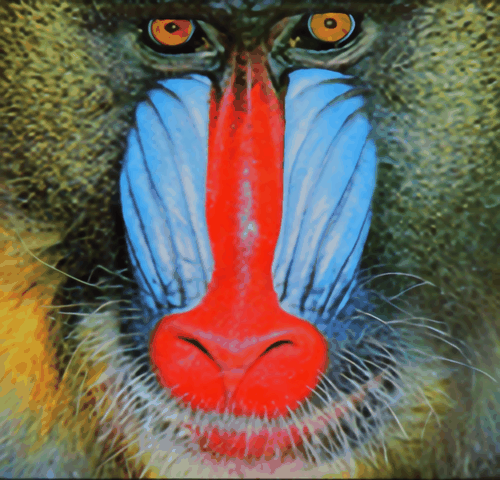

In [41]:
from IPython.display import Image
Image(open('results/baboon.gif','rb').read())

We can now achieve a continuous and smooth transition from PSNR-oriented outputs to GAN effects.

## What to Do Next?


- Blind super-resolution: The images captured form the real world have various down-sampling kernels. Blind super-resolution is indeed essential towards real-world applications. [IKC](https://arxiv.org/abs/1904.03377)
- Video super-resolution: Apply image super-resolution to videos. [EDVR](https://arxiv.org/abs/1905.02716), [BasicVSR](https://ckkelvinchan.github.io/projects/BasicVSR/), [BasicVSR++](https://ckkelvinchan.github.io/projects/BasicVSR++/)
- Real-World Video Super-Resolution: [RealBasicVSR](https://github.com/ckkelvinchan/RealBasicVSR)
- Metrics: Metrics are important for perceptual SR. [LPIPS](https://arxiv.org/pdf/1801.03924.pdf)